In [46]:
from importlib import reload
from src import parsing
from src import model_path
from src import models_path
from src import model_goal
from src import models_goal
from src import inception
from src import model_interface
from src import visualization
from src import util
from src import config
reload(parsing)
reload(model_path)
reload(models_path)
reload(model_goal)
reload(models_goal)
reload(inception)
reload(model_interface)
reload(visualization)
reload(util)
reload(config)

import seaborn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## define the models to compare
model_names = ['goal_simple_cnn_a', 'goal_transformer_b', 'goal_inception_e']
model_names_plain = ['cnn', 'transformer', 'inception time']

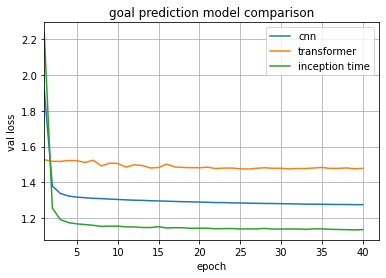

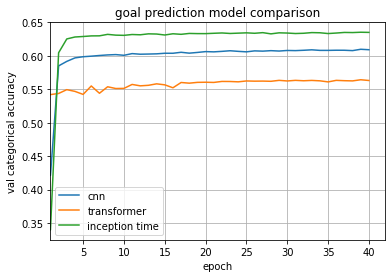

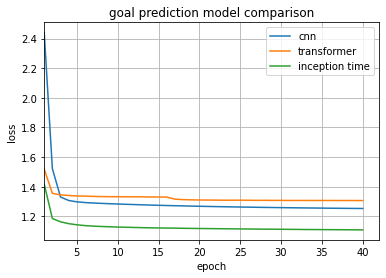

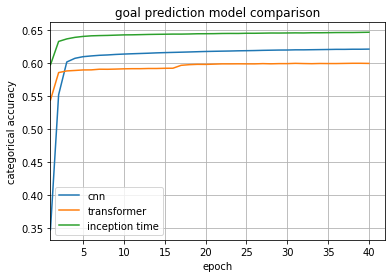

In [21]:
## Compare goal models while training
history_dicts = []
for history_file in model_names:
    history_dicts.append(model_interface.load_history(history_file, is_goal=True))

visualization.draw_histories(
    "val_loss",
    "val loss",
    graph_name = "goal prediction model comparison",
    save_file = 'goal_comparison_val_loss',
    names = model_names_plain,
    history_dicts = history_dicts,
)

visualization.draw_histories(
    "val_categorical_accuracy",
    "val categorical accuracy",
    graph_name = "goal prediction model comparison",
    save_file = 'goal_comparison_val_categorical_accuracy',
    names = model_names_plain,
    history_dicts = history_dicts,
)

visualization.draw_histories(
    "loss",
    "loss",
    graph_name = "goal prediction model comparison",
    save_file = 'goal_comparison_loss',
    names = model_names_plain,
    history_dicts = history_dicts,
)

visualization.draw_histories(
    "categorical_accuracy",
    "categorical accuracy",
    graph_name = "goal prediction model comparison",
    save_file = 'goal_comparison_categorical_accuracy',
    names = model_names_plain,
    history_dicts = history_dicts,
)

# val_categorical_accuracy


In [32]:
# load unused data for testing
train_data, eval_data, test_data = parsing.load_processed_data("part1_days_08_to_10")
assert test_data is None
print(train_data[0].shape, train_data[1].shape, train_data[2].shape)

# combine train and eval data into test data
test_data = parsing.unite_data( [train_data, eval_data] )
# can now discard the other data
train_data = None
eval_data = None
print(test_data[0].shape, test_data[1].shape, test_data[2].shape)

(4740636, 50, 2) (4740636, 25) (4740636, 50, 2)
(5271499, 50, 2) (5271499, 25) (5271499, 50, 2)


In [33]:
LIMIT = 50000
test_data_small = (test_data[0][:LIMIT], test_data[1][:LIMIT], test_data[2][:LIMIT])
print(test_data_small[0].shape, test_data_small[1].shape, test_data_small[2].shape)

(50000, 50, 2) (50000, 25) (50000, 50, 2)


In [49]:
# evaluate all models
for model_name in model_names:
    m = model_goal.ModelGoal()
    m.load(model_name)
    result = m.evaluate(test_data)
    print(f"{model_name}: {result}")

20592/20592 [==============================] - 24s 1ms/step - loss: 1.2971 - categorical_accuracy: 0.6187
goal_simple_cnn_a: [1.2970956563949585, 0.6187000870704651]
20592/20592 [==============================] - 82s 4ms/step - loss: 1.4442 - categorical_accuracy: 0.5860
goal_transformer_b: [1.444184422492981, 0.5859878063201904]
20592/20592 [==============================] - 129s 6ms/step - loss: 1.1488 - categorical_accuracy: 0.6461
goal_inception_e: [1.1487759351730347, 0.646063506603241]


In [43]:
# generate estimates for all goal models
goal_estimation_list = []
for model_name in model_names:
    m = model_goal.ModelGoal()
    m.load(model_name)
    goals_estimation = m.estimate(test_data_small, batch_limit=5000)
    goal_estimation_list.append(goals_estimation)

1/10: 0:5000
2/10: 5000:10000
3/10: 10000:15000
4/10: 15000:20000
5/10: 20000:25000
6/10: 25000:30000
7/10: 30000:35000
8/10: 35000:40000
9/10: 40000:45000
10/10: 45000:50000
1/10: 0:5000
2/10: 5000:10000
3/10: 10000:15000
4/10: 15000:20000
5/10: 20000:25000
6/10: 25000:30000
7/10: 30000:35000
8/10: 35000:40000
9/10: 40000:45000
10/10: 45000:50000
1/10: 0:5000
2/10: 5000:10000
3/10: 10000:15000
4/10: 15000:20000
5/10: 20000:25000
6/10: 25000:30000
7/10: 30000:35000
8/10: 35000:40000
9/10: 40000:45000
10/10: 45000:50000


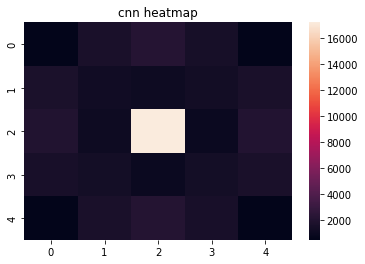

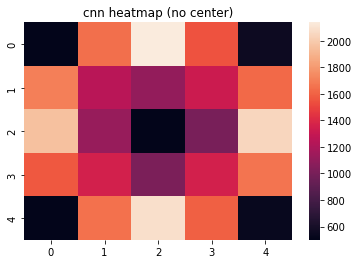

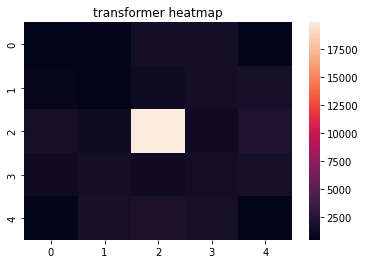

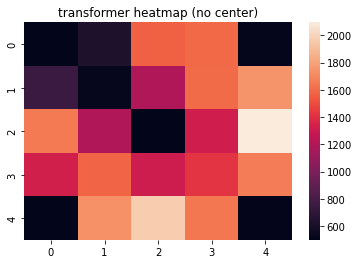

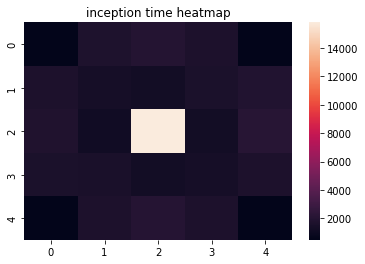

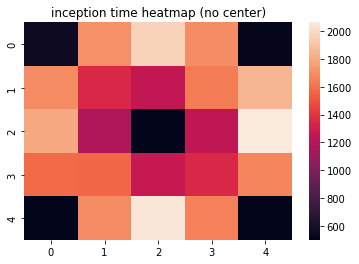

In [45]:
## plot heatmaps
for goal_estimation, model_name in zip(goal_estimation_list, model_names_plain):
    # sum up
    goal_estimation_sum = np.sum(goal_estimation, axis=0).reshape( (5, 5) )
    
    fig, ax = plt.subplots()
    plt.title(f"{model_name} heatmap")
    plt.xlabel("x")
    plt.ylabel("y")
    seaborn.heatmap(goal_estimation_sum, vmin=500)
    plt.savefig(f"figures/heatmap_{model_name}.pdf")
    plt.show()

    # zero out center point since its enormous outlier
    goal_estimation_sum[2,2] = 0
    plt.title(f"{model_name} heatmap (no center)")
    plt.xlabel("x")
    plt.ylabel("y")
    seaborn.heatmap(goal_estimation_sum, vmin=500)
    plt.savefig(f"figures/heatmap_no_center_{model_name}.pdf")
    plt.show()

(50000, 25) (50000,)
(50000, 25) (50000,)


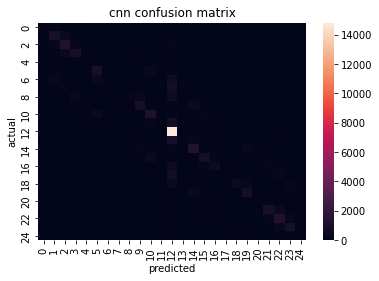

(50000, 25) (50000,)
(50000, 25) (50000,)


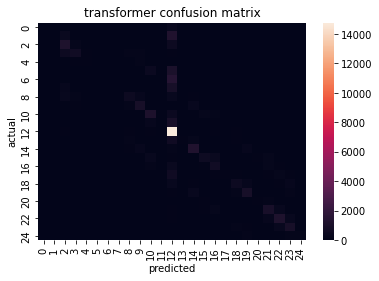

(50000, 25) (50000,)
(50000, 25) (50000,)


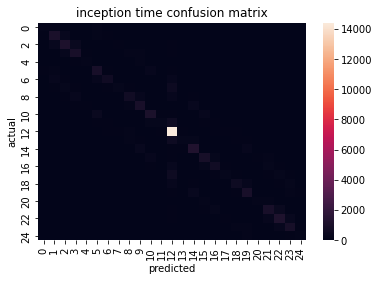

In [53]:
## confusion matrix
import sklearn.metrics

for goal_estimation, model_name in zip(goal_estimation_list, model_names_plain):
    real_goals = test_data_small[1]

    real_goals_bool = np.argmax(real_goals, axis=1)
    print(real_goals.shape, real_goals_bool.shape)

    # generate boolean, for confusion we just use the most likely one
    goal_estimation_bool = np.argmax(goal_estimation, axis=1)
    print(goal_estimation.shape, goal_estimation_bool.shape)

    confusion = sklearn.metrics.confusion_matrix(real_goals_bool, goal_estimation_bool)
    
    fig, ax = plt.subplots()
    plt.title(f"{model_name} confusion matrix")
    seaborn.heatmap(confusion)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.savefig(f"figures/confusion_{model_name}.pdf")
    plt.show()

    # # zero out center point since its enormous outlier
    # confusion[12,12] = 0
    # plt.title(f"{model_name} confusion (no center)")
    # plt.xlabel("x")
    # plt.ylabel("y")
    # seaborn.heatmap(confusion, vmin=500)
    # plt.show()
